In [1]:
# stanのバージョンが v3.3 になり import pystan ではなくではなく import stan とライブラリ名がが
# 変わると当時に、build 時に以下のエラーがでるようになった。
# 対策としてnest_asyncio というライブラリを使う必要があるため、最初の一回のみライブラリをインストールしておくしておく
# 一回 install すれば、あとはこのコマンドは不要なので、先頭にに#をつけてコメントにしておいてください。
## RuntimeError: asyncio.run() cannot be called from a running event loop

!pip install nest_asyncio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

input_dir = "/content/drive/MyDrive/input/"
output_dir = "/content/drive/MyDrive/output/"

# pystan と、パラメータの事後分布の推定結果を可視化するためのライブラリとして arviz を利用する。
import stan
import arviz
import nest_asyncio # stanのバージョンアップ対策
nest_asyncio.apply() # stanのバージョンアップ対策


Mounted at /content/drive


複数の階層を含むロジスティク回帰を試します。

## (1) 階層なしのロジスティック回帰

note6-4で学んだ通常のロジスティック回帰のコードの復習をします。ロジスティック回帰は、基本的に以下の式で表されます。。

$$p_i = \mathrm{logit}^{-1}(a + b_1 x_1 + b_2 x_2 + \cdots + b_m x_m)$$
$$ y_i \sim \mathrm{bernoulli}(p_i) $$


ただし、ここでの実装はは note9-1と同様にデザイン行列はつかわず、変数はバラしてつかいます。このノートではこれを多重の階層モデルに拡張します。

利用するデータ data-attendance-3.txtの各項目は以下の通り。
- A: 学生がアルバイト好きかを表す表す（（0:好きではない、1:好き））
- Score: 学生の学問への興味をスコア化したもの（200点満点）
- Weather：授業日の天気（A:晴れ, B:曇り, C:雨）
- Y：授業に出席したかどうかを表す（0:欠席, 1:出席）

学生の性質や日頃の行いから、授業に出席するかどうかを推定することを考える。

p[i] = inv_logit(b_1 + b_2 * A[i] + b_3 * Score [i] + b_4 * Weather)<BR>
y[i] = Bernoulli(p[i])

In [3]:
# 同一の学生(PersonID)について複数回の出席の記録があることに注意

!cat /content/drive/MyDrive/input/data-attendance-3.txt


PersonID,A,Score,Weather,Y
1,0,69,B,1
1,0,69,A,1
1,0,69,C,1
1,0,69,A,1
1,0,69,B,1
1,0,69,B,1
1,0,69,C,0
1,0,69,B,1
1,0,69,A,1
1,0,69,A,1
1,0,69,A,1
1,0,69,C,1
1,0,69,A,1
1,0,69,A,1
1,0,69,A,1
1,0,69,A,1
1,0,69,A,0
1,0,69,B,1
1,0,69,A,1
1,0,69,A,1
1,0,69,B,1
1,0,69,B,1
1,0,69,C,0
1,0,69,C,1
1,0,69,A,1
1,0,69,A,1
1,0,69,B,1
1,0,69,A,1
1,0,69,B,1
1,0,69,A,1
1,0,69,B,1
1,0,69,A,1
1,0,69,B,1
1,0,69,A,0
1,0,69,C,0
1,0,69,A,1
1,0,69,A,1
1,0,69,A,1
1,0,69,B,1
1,0,69,A,1
1,0,69,A,1
1,0,69,B,1
1,0,69,B,1
2,1,145,A,1
2,1,145,A,1
2,1,145,A,1
2,1,145,C,1
2,1,145,A,0
2,1,145,B,1
2,1,145,B,1
2,1,145,B,1
2,1,145,B,0
2,1,145,A,1
2,1,145,A,1
2,1,145,A,1
2,1,145,A,1
2,1,145,A,1
2,1,145,C,1
2,1,145,A,0
2,1,145,C,1
2,1,145,A,1
2,1,145,A,0
2,1,145,A,0
2,1,145,A,1
2,1,145,B,0
2,1,145,A,1
2,1,145,B,1
2,1,145,C,1
2,1,145,B,0
2,1,145,C,1
2,1,145,C,1
2,1,145,A,1
2,1,145,B,1
2,1,145,A,1
2,1,145,B,1
2,1,145,C,0
2,1,145,A,1
2,1,145,A,1
2,1,145,C,0
2,1,145,B,1
2,1,145,B,1
2,1,145,C,1
2,1,145,B,1
2,1,145,A,1
2,1,145,

In [4]:
data = pd.read_csv(input_dir+'data-attendance-3.txt') 

print(data.shape) # 次元を確認
data.head() # データの先頭を確認確認 data.tail() で後ろからも確認できる

(2396, 5)


,PersonID,A,Score,Weather,Y
0,1,0,69,B,1
1,1,0,69,A,1
2,1,0,69,C,1
3,1,0,69,A,1
4,1,0,69,B,1


In [5]:
# 背景知識として、経験から曇りの影響と雨の影響の比を1:5に固定する意味で、Bをを0.2に設定する。
weather_pattern = { # 変換用辞書
    'A': 0,
    'B': 0.2,
    'C': 1
}

data_re = data.replace(weather_pattern)
data_re.head()

,PersonID,A,Score,Weather,Y
0,1,0,69,0.2,1
1,1,0,69,0.0,1
2,1,0,69,1.0,1
3,1,0,69,0.0,1
4,1,0,69,0.2,1


In [6]:
# 0、1の2値の出現確率を推定したい場合、ベルヌーイ分布を使う
# ここでは、A、Score、WeatherからYを推定する。A、Score、Weatherは出席確率としてロジスティック関数を使って推定し、
# 推定した値qを使って、Yをベルヌーイ分布に従うものとして計算する。

y = data_re['Y'].values
x1 = data_re['A'].values
x2 = data_re['Score'].values/200 # 注：Scoreは200点満点なので割合に修正する。
x3 = data_re['Weather'].values
N = data.shape[0]

# Stan に入力するデータを作成
stan_data = {
    'N': N,
    'x1': x1, # A
    'x2': x2, # Score (%)
    'x3': x3, # Weather (0, 0.2, 1.0)
    'y': y # 0 or 1
}

#stan_data

In [7]:
stan_code = """
data {
    int N;
    int<lower=0, upper=1> x1[N];
    real<lower=0, upper=1> x2[N];
    real<lower=0, upper=1> x3[N];
    int<lower=0> y[N];
}

parameters {
    real b0;
    real b1;
    real b2;
    real b3;
}

transformed parameters {
    real p[N];
    for (i in 1:N){
        p[i] = b0+ b1*x1[i] + b2*x2[i] + b3*x3[i];
    }

}

model {
    for (i in 1:N) {
        y[i] ~ bernoulli_logit(p[i]);
    }
}
"""

In [8]:
model = stan.build(stan_code, data=stan_data, random_seed=1)
# MCMCの実行
fit = model.sample(
    num_warmup = 1000, # バーンイン期間
    num_chains = 4, #チェーン数
    num_samples= 2000, # 乱数生成の繰り返し回数
    num_thin = 1, #間引き数
)

Building...



Building: 41.4s, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   1% (101/12000)
Sampling:   2% (200/12000)
Sampling:   2% (300/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1801/12000)
Sampling:  16% (1901/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)
Sampling:  18% (2101/12000)
Sampling:  18% (2201/12000)
Sampling:  19% (2300/12000)
Sampling:  20% (2400/12000)
Sampling:  21% (2500/12000)
Sampling:  22% (2600/12000)
Sampling:  22% (2700/12000)
Sampling:  23% (2800/12000)
Sampling:  24% (2900/12000)
Sampling:  25% (3000/12000)
Sampling:  26% (3100/12000)
Samp

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,0.169,0.226,-0.250,0.592,0.004,0.003,3683.0,4338.0,1.0
b1,-0.622,0.094,-0.801,-0.449,0.001,0.001,4868.0,4161.0,1.0
b2,1.963,0.362,1.286,2.644,0.006,0.004,3793.0,4420.0,1.0
b3,-0.461,0.123,-0.708,-0.244,0.002,0.001,5861.0,4717.0,1.0
p[0],0.754,0.113,0.529,0.955,0.002,0.001,3897.0,4483.0,1.0
...,...,...,...,...,...,...,...,...,...
p[2391],0.426,0.075,0.288,0.568,0.001,0.001,5429.0,5594.0,1.0
p[2392],0.518,0.080,0.365,0.663,0.001,0.001,5650.0,5646.0,1.0
p[2393],0.518,0.080,0.365,0.663,0.001,0.001,5650.0,5646.0,1.0
p[2394],0.057,0.121,-0.161,0.286,0.002,0.001,5639.0,5467.0,1.0


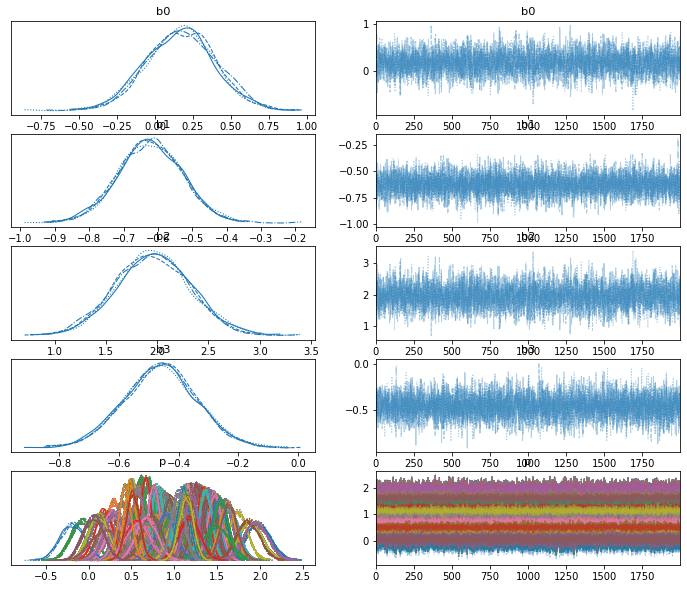

In [9]:
# MCMCの経過を簡易表示, muとsigmaのiter変化が見られる
arviz.plot_trace(fit)

#  Gelman-Rubin 統計量 (r_hat)、Highest density interval (HDI) などの簡易表示
summary = arviz.summary(fit)
summary

In [10]:
result = fit.to_frame()

print (result.columns)

# 先頭を表示
result.head()

Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
       'divergent__', 'energy__', 'b0', 'b1', 'b2',
       ...
       'p.2387', 'p.2388', 'p.2389', 'p.2390', 'p.2391', 'p.2392', 'p.2393',
       'p.2394', 'p.2395', 'p.2396'],
      dtype='object', name='parameters', length=2407)


parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,b0,b1,b2,...,p.2387,p.2388,p.2389,p.2390,p.2391,p.2392,p.2393,p.2394,p.2395,p.2396
draws,,,,,,,,,,,,,,,,,,,,,
0,-1385.743714,0.989374,0.141320,4.0,31.0,0.0,1387.288129,0.350616,-0.592686,1.412675,...,0.457205,0.457205,0.457205,0.374004,0.041201,0.374004,0.457205,0.457205,0.041201,0.041201
1,-1382.635140,0.937216,0.154370,4.0,31.0,0.0,1383.416018,0.097478,-0.477896,1.968646,...,0.594062,0.594062,0.594062,0.517690,0.212200,0.517690,0.594062,0.594062,0.212200,0.212200
2,-1383.930307,0.994785,0.140061,5.0,31.0,0.0,1385.578589,-0.015360,-0.445492,2.048448,...,0.553130,0.553130,0.553130,0.496547,0.270214,0.496547,0.553130,0.553130,0.270214,0.270214
3,-1381.531727,0.999276,0.154260,5.0,31.0,0.0,1383.193888,0.347833,-0.594648,1.618254,...,0.554221,0.554221,0.554221,0.462929,0.097760,0.462929,0.554221,0.554221,0.097760,0.097760
4,-1386.194374,1.000000,0.141320,5.0,31.0,0.0,1387.832373,0.379161,-0.736937,1.989489,...,0.627021,0.627021,0.627021,0.500421,-0.005982,0.500421,0.627021,0.627021,-0.005982,-0.005982


In [11]:
b0, b1, b2, b3 = np.mean(result['b0']), np.mean(result['b1']), np.mean(result['b2']), np.mean(result['b3']) # sigma はいつもの方法で取り出せます
print (b0, b1, b2, b3)

0.1685475139898835 -0.6219362352200497 1.963059731346897 -0.46097244904734885


In [12]:
# 参考：【pandas】filter：列の抽出【データフレーム処理】 https://datasciencemore.com/python-pandas-filter
# mu_pred.1 ... mu_pred.31 からまでを抽出する方法をテスト
# 正規表現を使って、、mu_predの後ろに 0-9 までの数字が続いたのちに終わる($)、列名 (axis=1) を抽出
print(result.filter(regex='p.[0-9]+$', axis=1))

parameters       p.1       p.2       p.3       p.4       p.5       p.6  \
draws                                                                    
0           0.754788  0.837989  0.421985  0.837989  0.754788  0.754788   
1           0.700289  0.776661  0.394799  0.776661  0.700289  0.700289   
2           0.634771  0.691354  0.408438  0.691354  0.634771  0.634771   
3           0.814838  0.906130  0.449669  0.906130  0.814838  0.814838   
4           0.938934  1.065535  0.432532  1.065535  0.938934  0.938934   
...              ...       ...       ...       ...       ...       ...   
7995        0.629519  0.736007  0.203569  0.736007  0.629519  0.629519   
7996        0.976326  1.073234  0.588696  1.073234  0.976326  0.976326   
7997        0.565863  0.651712  0.222466  0.651712  0.565863  0.565863   
7998        0.711782  0.824368  0.261435  0.824368  0.711782  0.711782   
7999        0.698546  0.771477  0.406821  0.771477  0.698546  0.698546   

parameters       p.7       p.8       

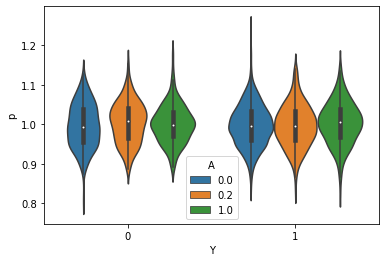

In [13]:
# バイオリンプロットという最近の統計の可視化表記で変数間の関係をみる。
# バイオリンプロットの見方については、https://stats.biopapyrus.jp/python/violinplot.html や、
# 箱ひげ図との違い https://yyhhyy.hatenablog.com/entry/2016/08/20/220000　など他のWebを確認のこと。
import seaborn as sns

p = result.filter(regex='p.[0-9]+$', axis=1).T
# 各pの中央値を取得
p_median = []
for i in range(N):
    p_median.append(np.median(p[i]))

# pとyの関係を確認
plot_df = pd.DataFrame({
    'Y': y,
    'A': x3, # 天気
    'p': p_median
})
sns.violinplot(x='Y', y='p', hue='A', data=plot_df)
plt.show()

- y=0が欠席、y=1が出席なので、pが小さいほどy=0、大きいほどy=1に振れていれば良い予測モデルといえる。今回は差がないので良い予測モデルとはいえない。

## (2) 階層ありのロジスティック回帰

(1) では出席ごとのデータに対して天気が出席確率に影響を及ぼすことを考慮するモデリングを行った。
つまり、切片と天気、スコア、アルバイトの好き嫌いの線形結合をロジスティック関数に噛ませて出席確率として計算し、ベルヌーイ分布によって複数回の試行結果を観測していた。

(2) では、そこにグループごとの傾向を加える取り組みを行う。ここではグループの種類として、学生ごとの差、科目ごとの差、授業ごとの差の3種類のグループが考えられる。

- 学生ごと：アルバイトの好き嫌い、Score、学生差
- 科目ごと：科目差
- 授業ごと：天気

これらを最終的に和をとって、ロジスティック関数を通すことで出席確率になると考える。

x[i] = b_0 + x_s[SID[i]] + x_c[CID[i]] + x_w[i]<BR>
p[i] = inv_logit(x[i])<BR>
y[i] = Bernoulli(p[i])<BR>

x_s[s] = b_1 * A[s] + b_2 * Score [s] + bs[s]<BR>
bs[s] = N(0, sigma_s)<BR>

x_c[c] = bc[c]<BR>
bc[c] = N(0, sigma_c)<BR>

x_w[i] = b_3 * Weather[i]<BR>

そこで(1)をデータを以下のの2つのデータに分け、学生のデータと、出席のデータを用意した
出席のデータには、CourseIDが付与されていることに注意。



In [14]:
data_s = pd.read_csv(input_dir+'data-attendance-4-1.txt') 

print(data_s.shape) # 次元を確認
data_s.head() # データの先頭を確認確認 data.tail() で後ろからも確認できる
# PersonID: 学生ID
# A: アルバイトが 0嫌い、1好き
# Score: 学力テストのスコア

(50, 3)


,PersonID,A,Score
0,1,0,69
1,2,1,145
2,3,0,125
3,4,1,86
4,5,1,158


In [15]:
# 出席ごとのデータ
data_a = pd.read_csv(input_dir+'data-attendance-4-2.txt')
data_a.head()
# PersonID: 学生ID
# CourseID: 授業ID
# Weather: 天気（A晴れ、B曇り、C雨）
# Y: 出席 1した、0していない

,PersonID,CourseID,Weather,Y
0,1,3,B,1
1,1,9,A,1
2,1,1,C,1
3,1,9,A,1
4,1,7,B,1


In [16]:
# 背景知識として、経験から曇りの影響と雨の影響の比を1:5に固定する意味で、Bをを0.2に設定する。
weather_pattern = { # 変換用辞書
    'A': 0,
    'B': 0.2,
    'C': 1
}

data_a_re = data_a.replace(weather_pattern) # (1)と同様に置換しておく
data_a_re.head()

,PersonID,CourseID,Weather,Y
0,1,3,0.2,1
1,1,9,0.0,1
2,1,1,1.0,1
3,1,9,0.0,1
4,1,7,0.2,1


In [17]:
# PersonIDごとのA
xx1 = data_s['A'].values
print(xx1)

# PersonIDごとのScore
xx2 = data_s['Score'].values/200  # 注：Scoreは200点満点なので割合に修正する。
print(xx2)

# 授業ごとの天気
xx3 = data_a_re['Weather'].values
print(xx3)

# 授業ごとの学生ID
xx4 = data_a_re['PersonID'].values
print(xx4)
SS = len(np.unique(xx4))

# 授業ごとの科目ID
xx5 = data_a_re['CourseID'].values
print(xx5)
CC = len(np.unique(xx5))

# 授業ごとの出席
yy = data_a_re['Y'].values
NN = len(yy)

# Stan に入力するデータを作成
stan_data2 = {
    'N': NN, # データ数
    'S': SS, # 追加：学生(Student)の種類の数
    'C': CC, # 追加：コース(Course)の種類の数
    'x1': xx1, # A
    'x2': xx2, # Score (%)
    'x3': xx3, # Weather (0, 0.2, 1.0)
    'SID': xx4, # 追加：SID
    'CID': xx5, # 追加：CID    
    'y': yy # 0 or 1
}

#stan_data2

[0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 1]
[0.345 0.725 0.625 0.43  0.79  0.665 0.555 0.735 0.73  0.725 0.705 0.685
 0.59  0.555 0.545 0.495 0.57  0.41  0.925 0.78  0.43  0.54  0.53  0.715
 0.585 0.64  0.595 0.595 0.805 0.565 0.825 0.37  0.69  0.62  0.63  0.655
 0.525 0.55  0.445 0.44  0.645 0.665 0.61  0.74  0.91  0.525 0.255 0.75
 0.495 0.495]
[0.2 0.  1.  ... 0.  1.  1. ]
[ 1  1  1 ... 50 50 50]
[ 3  9  1 ...  2 10  5]


In [18]:
print (xx3)

[0.2 0.  1.  ... 0.  1.  1. ]


In [19]:
stan_code2 = """
data {
    int S; // 学生(Strudent)数
    int C; // コース(Course)数
    int N; // 授業数

    int<lower=0, upper=1> x1[S]; // A
    real<lower=0, upper=1> x2[S]; // Score

    int<lower=1, upper=N> SID[N]; // StudentID
    int<lower=1, upper=C> CID[N]; // CourseID
    real<lower=0, upper=1> x3[N]; // W
    int<lower=0, upper=1> y[N];
}

parameters {
    real b0; // 授業ごと
    real b1; // A:アルバイトの好き嫌い
    real b2; // S:スコア
    real b3; // W:天気
    real bs[S]; // 学生ごと
    real bc[C]; // コースごと
    real<lower=0> sigma_s; // 学生ごとのばらつき
    real<lower=0> sigma_c; // コースごとのばらつき
}

transformed parameters {
    real xs[S];
    real xc[C];
    real x[N];
    real xw[N];
    real p[N];

    for (s in 1:S) { // 学生ごと
        xs[s] = b1 * x1[s] + b2 * x2[s] + bs[s];
    }
    for (c in 1:C) { // コースごと
        xc[c] = bc[c];
    }
    for (n in 1:N) { // 授業ごと
        xw[n] = b3 * x3[n];
        x[n] = b0 + xs[SID[n]] + xc[CID[n]] + xw[n];
        p[n] = inv_logit(x[n]);
    }
}

model {
    for (s in 1:S) {
        bs[s] ~ normal(0, sigma_s);
    }
    for (c in 1:C) {
        bc[c] ~ normal(0, sigma_c);
    }
    for (n in 1:N) {
        y[n] ~ bernoulli(p[n]);
    }
}

"""

In [20]:
model2 = stan.build(stan_code2, data=stan_data2, random_seed=1)
# MCMCの実行
fit2 = model2.sample(
    num_warmup = 1000, # バーンイン期間
    num_chains = 4, #チェーン数
    num_samples= 2000, # 乱数生成の繰り返し回数
    num_thin = 1, #間引き数
)

Building...



Building: 34.8s, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   1% (101/12000)
Sampling:   2% (200/12000)
Sampling:   2% (300/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (1901/12000)
Sampling:  17% (2002/12000)
Sampling:  18% (2101/12000)
Sampling:  18% (2200/12000)
Sampling:  19% (2300/12000)
Sampling:  20% (2400/12000)
Sampling:  21% (2500/12000)
Sampling:  22% (2600/12000)
Sampling:  22% (2700/12000)
Sampling:  23% (2800/12000)
Sampling:  24% (2900/12000)
Sampling:  25% (3000/12000)
Sampling:  26% (3100/12000)
Sampling:  27% (3200/12000)
Samp

In [21]:
result2 = fit2.to_frame()

print (result2.columns)

# 先頭を表示
result2.head()

Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
       'divergent__', 'energy__', 'b0', 'b1', 'b2',
       ...
       'p.2387', 'p.2388', 'p.2389', 'p.2390', 'p.2391', 'p.2392', 'p.2393',
       'p.2394', 'p.2395', 'p.2396'],
      dtype='object', name='parameters', length=7321)


parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,b0,b1,b2,...,p.2387,p.2388,p.2389,p.2390,p.2391,p.2392,p.2393,p.2394,p.2395,p.2396
draws,,,,,,,,,,,,,,,,,,,,,
0,-1147.765167,0.998007,0.067196,6.0,63.0,0.0,1174.362201,0.832755,-0.687859,1.712898,...,0.542401,0.844937,0.793857,0.499851,0.148874,0.764538,0.793857,0.291022,0.621354,0.335587
1,-1135.182430,0.967682,0.075173,6.0,63.0,0.0,1167.255090,-1.404876,-0.712751,1.851223,...,0.689537,0.890001,0.934840,0.660325,0.268579,0.926241,0.934840,0.416831,0.880533,0.532929
2,-1117.422665,0.981833,0.071036,6.0,63.0,0.0,1146.198640,1.035060,-0.558893,1.386484,...,0.675410,0.888147,0.871650,0.636560,0.210671,0.851110,0.871650,0.387121,0.741576,0.467870
3,-1131.812594,0.968799,0.073495,5.0,63.0,0.0,1155.526364,1.759316,-0.636998,1.410723,...,0.782441,0.922514,0.932055,0.743043,0.270807,0.916872,0.932055,0.524976,0.821738,0.547216
4,-1150.991088,0.991464,0.067196,6.0,63.0,0.0,1185.929195,0.733546,-0.737224,2.217326,...,0.804143,0.963863,0.937577,0.779730,0.367428,0.928314,0.937577,0.549392,0.877384,0.661707


In [22]:
bb0, bb1, bb2, bb3 = np.mean(result2['b0']), np.mean(result2['b1']), np.mean(result['b2']), np.mean(result2['b3'])
print (bb0, bb1, bb2, bb3)

sigma_s, sigma_c = np.mean(result2['sigma_s']), np.mean(result2['sigma_c'])
print (sigma_s, sigma_c)

0.812872544238 -0.7974657118362679 1.963059731346897 -0.7778843236179521
0.35357434254408393 1.4254875044377175


- パラメータ b0 から b3 のうち、b1（アルバイト）とb3（天候) はマイナスなので、出席において同程度のマイナスの影響だとわかる。
- さらに、b2 は学生の学問への興味をスコア化したものへの係数で、プラスの影響だとわかる。。
- sigma_s は sigma_cよりも小さく、学生差は科目差よりも小さいとわかる。


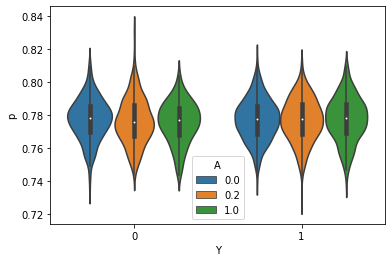

In [23]:
# バイオリンプロットという最近の統計の可視化表記で変数間の関係をみる。
# バイオリンプロットの見方については、https://stats.biopapyrus.jp/python/violinplot.html や、
# 箱ひげ図との違い https://yyhhyy.hatenablog.com/entry/2016/08/20/220000　など他のWebを確認のこと。
import seaborn as sns

pp = result2.filter(regex='p.[0-9]+$', axis=1).T
# 各pの中央値を取得
pp_median = []
for i in range(N):
    pp_median.append(np.median(pp[i]))

# pとyの関係を確認
# y=0が欠席、y=1が出席なので、pが小さいほどy=0、大きいほどy=1に振れていれば良い予測モデルといえる。
# 今回は差がないので良い予測モデルとはいえない。
plot_df2 = pd.DataFrame({
    'Y': yy,
    'A': xx3, # 天気
    'p': pp_median
})
sns.violinplot(x='Y', y='p', hue='A', data=plot_df2)
plt.show()

- (1) と比べると (2) のほうが、pが小さいほどy=0、大きいほどy=1に振れており、良い予測モデルといえる。

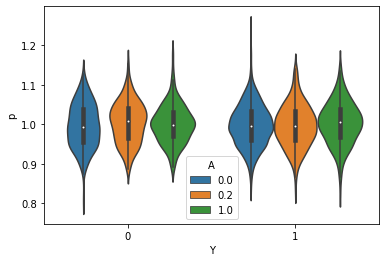

In [24]:
# (1) を比較のため表示
sns.violinplot(x='Y', y='p', hue='A', data=plot_df)
plt.show()

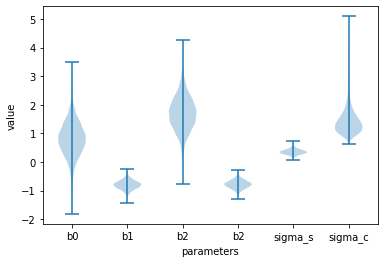

In [25]:
# (2) における各変数の応答変数に対する影響度を確認する(おまけ)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.violinplot([result2['b0'],
               result2['b1'],
               result2['b2'],
               result2['b3'],
               result2['sigma_s'],
               result2['sigma_c']])
ax.set_xticks([1, 2, 3, 4, 5, 6])
ax.set_xticklabels(['b0', 'b1', 'b2', 'b2', 'sigma_s', 'sigma_c'])
ax.set_xlabel('parameters')
ax.set_ylabel('value')
plt.show()
plt.close()